In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense, Activation
import matplotlib.pylab as plt   # 绘制图像库

In [2]:
def GM11(x0): #自定义灰色预测函数
  import numpy as np
  x1 = x0.cumsum() #1-AGO序列
  z1 = (x1[:len(x1)-1] + x1[1:])/2.0
  z1 = z1.reshape((len(z1),1))
  B = np.append(-z1, np.ones_like(z1), axis = 1)
  Yn = x0[1:].reshape((len(x0)-1, 1))
  [[a],[b]] = np.dot(np.dot(np.linalg.inv(np.dot(B.T, B)), B.T), Yn) #计算参数
  f = lambda k: (x0[0]-b/a)*np.exp(-a*(k-1))-(x0[0]-b/a)*np.exp(-a*(k-2)) #还原值
  delta = np.abs(x0 - np.array([f(i) for i in range(1,len(x0)+1)]))
  C = delta.std()/x0.std()
  P = 1.0*(np.abs(delta - delta.mean()) < 0.6745*x0.std()).sum()/len(x0)
  return f, a, b, x0[0], C, P #返回灰色预测函数、a、b、首项、方差比、小残差概率

In [5]:
data = pd.read_csv('/data1_qiyeshuju.csv') #读取数据
data.index = range(2000,2020) # 标注索引信息年份

In [6]:
data.loc[2020] = None
data.loc[2021] = None
data.loc[2022] = None
l = ['x1', 'x2', 'x3', 'x4', 'x5', 'x7']
l1 = ['x3','x5','x7']
for i in l1:
  f,_,_,_,C,_ = GM11(data[i].loc[range(2000,2020)].values)
  print("%s后验差比值：%0.4f"%(i,C))   #后验差比值c，即：真实误差的方差同原始数据方差的比值。
  data[i].loc[2020] = f(len(data)-2) #2014年预测结果
  data[i].loc[2021] = f(len(data)-1) #2015年预测结果
  data[i].loc[2022] = f(len(data))  # 2016年预测结果
  data[i] = data[i].round(2) #保留两位小数

data[l1+['y']].to_csv('GM11.csv') #结果输出

x3后验差比值：0.1239
x5后验差比值：0.0447
x7后验差比值：0.1048


<ipython-input-6-468de5217042>:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data.loc[2020] = None
<ipython-input-6-468de5217042>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data.loc[2021] = None
<ipython-input-6-468de5217042>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data.loc[2022] = None


In [7]:
data = pd.read_csv('GM11.csv',index_col = 0) #读取数据
feature = ['x3','x5','x7']  # 提取特征

In [8]:
data_train = data.loc[range(2000,2020)] #取2014年前的数据建模
print(data_train)
data_mean = data_train.mean()
data_std = data_train.std()
data_train = (data_train - data_mean)/data_std  #数据标准化 后进行训练

x_train = data_train[feature].values #特征数据
y_train = data_train['y'].values #标签数据

           x3        x5       x7        y
2000   448.19   6212.70   525.71    64.87
2001   549.97   7601.73   618.25    99.75
2002   686.44   8092.82   638.94    88.11
2003   802.59   8767.98   656.58   106.07
2004   904.57   9422.33   758.83   137.32
2005  1000.69   9751.44   878.26   188.14
2006  1121.13  11349.47   923.67   219.91
2007  1248.29  11467.35   978.21   271.91
2008  1370.68  10671.78  1009.24   269.10
2009  1494.27  11570.58  1175.17   300.55
2010  1677.77  13120.83  1348.93   338.45
2011  1905.84  14468.24  1519.16   408.86
2012  2199.14  15444.93  1696.38   476.72
2013  2624.24  18951.32  1863.34   838.99
2014  3187.39  20835.95  2105.54   843.14
2015  3615.77  22820.89  2659.85  1107.67
2016  4476.38  25011.61  3263.57  1399.16
2017  5243.03  28209.74  3412.21  1535.14
2018  5977.27  30490.44  3758.39  1579.68
2019  6882.85  33156.83  4454.55  2088.14


In [13]:
model = Sequential() #建立模型
model.add(Dense(12,activation='relu',input_dim=3))
model.add(Dense(24,activation='relu'))  # 隐藏层
model.add(Dense(1))  # 输出层
model.compile(loss='mean_squared_error', optimizer='adam') #编译模型
model.fit(x_train, y_train, epochs = 100, batch_size = 16,verbose=2) #训练模型，训练1000次
model.save_weights('net.model') #保存模型参数

Epoch 1/100
2/2 - 1s - loss: 0.6587 - 1s/epoch - 578ms/step
Epoch 2/100
2/2 - 0s - loss: 0.5794 - 9ms/epoch - 5ms/step
Epoch 3/100
2/2 - 0s - loss: 0.5141 - 9ms/epoch - 4ms/step
Epoch 4/100
2/2 - 0s - loss: 0.4485 - 9ms/epoch - 4ms/step
Epoch 5/100
2/2 - 0s - loss: 0.3827 - 9ms/epoch - 4ms/step
Epoch 6/100
2/2 - 0s - loss: 0.3361 - 9ms/epoch - 5ms/step
Epoch 7/100
2/2 - 0s - loss: 0.2878 - 9ms/epoch - 5ms/step
Epoch 8/100
2/2 - 0s - loss: 0.2446 - 9ms/epoch - 4ms/step
Epoch 9/100
2/2 - 0s - loss: 0.2024 - 9ms/epoch - 5ms/step
Epoch 10/100
2/2 - 0s - loss: 0.1645 - 10ms/epoch - 5ms/step
Epoch 11/100
2/2 - 0s - loss: 0.1300 - 9ms/epoch - 5ms/step
Epoch 12/100
2/2 - 0s - loss: 0.1068 - 9ms/epoch - 5ms/step
Epoch 13/100
2/2 - 0s - loss: 0.0825 - 9ms/epoch - 5ms/step
Epoch 14/100
2/2 - 0s - loss: 0.0639 - 9ms/epoch - 4ms/step
Epoch 15/100
2/2 - 0s - loss: 0.0484 - 10ms/epoch - 5ms/step
Epoch 16/100
2/2 - 0s - loss: 0.0336 - 10ms/epoch - 5ms/step
Epoch 17/100
2/2 - 0s - loss: 0.0279 - 9ms/ep

In [14]:
x = ((data[feature] - data_mean[feature])/data_std[feature]).values
data[u'y_pred'] = model.predict(x) * data_std['y'] + data_mean['y']
data.to_csv('result.csv')

1/1 [==============================] - 0s 96ms/step


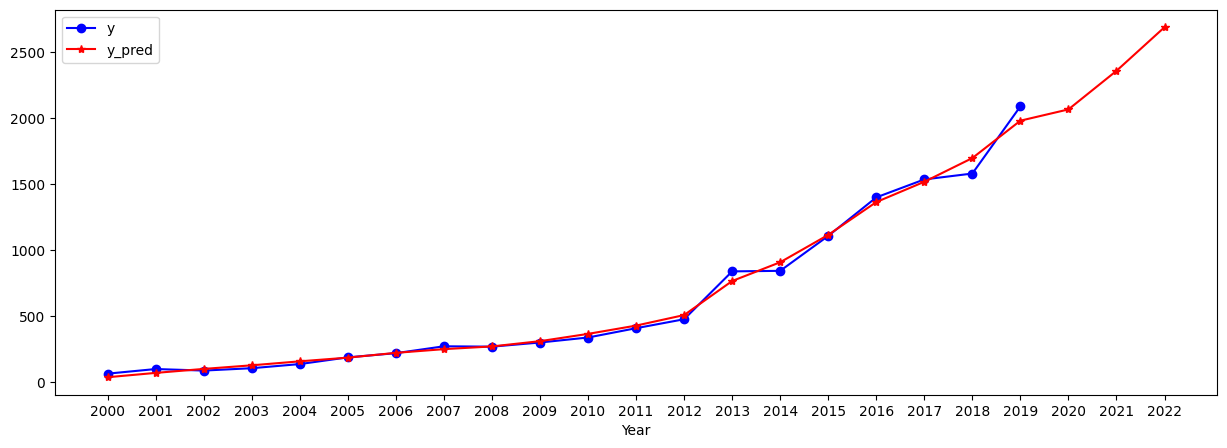

In [15]:
p = pd.read_csv('result.csv')
p = p[['y','y_pred']].copy()
p.index=range(2000,2023)
p.plot(style=['b-o','r-*'],xticks=p.index,figsize=(15,5))
plt.xlabel("Year")
plt.show()

# 新段落